## Overview

This project aims to investigate the over-smoothing phenomenon on **graph attention networks (GATs)**.   
There are two questions: 


1.   Do GATs suffer from over-smoothing? 
2.   If yes, do the tackling methods (e.g. skip connections, jumping knowledge connection) work on GATs?  





**Keywords about this project:**
* Dataset: CORA  
* Task: node classification  
* Baseline model: graph convolutional networks (GNNs)
* Research model: graph attention networks (GATs)
* Tackling method 1: skip connections  
* Tackling method 2: jumping knowledge connection  
* Visulazation method: T-SNE for dimensionality reduction
* Training strategy: early-stopping

## Part 1: Preparation

*   packages installation 
*   import libraries
*   dataset loading
*   define log functions

In [ ]:
!python -c "import torch; print(torch.__version__)"

1.13.0+cu116


In [ ]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
import torch
import os
import typing
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets
from torch_geometric.nn import GATConv, GCNConv, MessagePassing
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
warnings.simplefilter(action='ignore', category=Warning, lineno=0, append=False)

In [ ]:
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


In [ ]:
def log(msg):
  f = open(r"log.txt",'a')
  f.write(msg)
  f.write('\n')
  f.close()
def print_log(msg):
  print(msg)
  f = open(r"log.txt",'a')
  f.write(msg)
  f.write('\n')
  f.close()

## Part 2: GAT vs GCN


#### Model construction

In [ ]:
class GAT(nn.Module):
  def __init__(self, input_dim: int, hid_dim: int, n_classes: int, n_layers: int, dropout_ratio: float = 0.3):
    super(GAT, self).__init__()
    self.n_layers = n_layers
    self.relu_layer = nn.ReLU()
    self.dropout_layer = nn.Dropout(dropout_ratio)
    layers_list = []
    if n_layers == 1:
      layers_list.append(GATConv(input_dim, n_classes))
    else:
      layers_list.append(GATConv(input_dim, hid_dim))
      for i in range(n_layers - 2): 
        layers_list.append(GATConv(hid_dim, hid_dim))
      layers_list.append(GATConv(hid_dim, n_classes))
    self.layers = nn.ModuleList(layers_list)

  def forward(self, X, A) -> torch.Tensor:
    X = self.generate_node_embeddings(X, A)
    X = F.softmax(X, dim=1)
    return X

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    for layer in self.layers[:-1]:
      X = layer(X, A)
      X = self.relu_layer(X)
      X = self.dropout_layer(X)
    X = self.layers[-1](X, A)
    return X
  
  def param_init(self):
    def _reset_module_parameters(module):
        for layer in module.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            elif hasattr(layer, 'children'):
                for child_layer in layer.children():
                    _reset_module_parameters(child_layer)
    _reset_module_parameters(self)

In [ ]:
class GCN(nn.Module):
  def __init__(self, input_dim: int, hid_dim: int, n_classes: int, n_layers: int, dropout_ratio: float = 0.3):
    super(GCN, self).__init__()
    self.n_layers = n_layers
    self.relu_layer = nn.ReLU()
    self.dropout_layer = nn.Dropout(dropout_ratio)
    layers_list = []
    if n_layers == 1:
      layers_list.append(GCNConv(input_dim, n_classes))
    else:
      layers_list.append(GCNConv(input_dim, hid_dim))
      for i in range(n_layers - 2): 
        layers_list.append(GCNConv(hid_dim, hid_dim))
      layers_list.append(GCNConv(hid_dim, n_classes))
    self.layers = nn.ModuleList(layers_list)

  def forward(self, X, A) -> torch.Tensor:
    X = self.generate_node_embeddings(X, A)
    X = F.softmax(X, dim=1)
    return X

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    for layer in self.layers[:-1]:
      X = layer(X, A)
      X = self.relu_layer(X)
      X = self.dropout_layer(X)
    X = self.layers[-1](X, A)
    return X
  
  def param_init(self):
    def _reset_module_parameters(module):
        for layer in module.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            elif hasattr(layer, 'children'):
                for child_layer in layer.children():
                    _reset_module_parameters(child_layer)
    _reset_module_parameters(self)

#### Design train and evaluation functions

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(1119)

data = dataset.data
data = data.to(device)

PARAMS = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    # "num_epochs": 100,  # number of total training epochs
    "max_patience": 10, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
}
PARAMS["n_classes"] = dataset.num_classes # number of target classes
PARAMS["input_dim"] = dataset.num_features # size of input features

In [ ]:
def evaluate(model, data, mask):
    model.eval()
    y_gt = data.y[mask]
    y = model(data.x, data.edge_index)[mask]
    acc = (y.argmax(dim=-1) == y_gt).sum().float() / mask.sum()   
    return acc.item()

In [ ]:
def train(model, params) -> torch.nn.Module:
  model.param_init()  
  model.train() 
  epoch = 0
  best_score = 0
  best_model = model
  num_worse = 0
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay = params["weight_decay"])

  while True:
    y_gt = data.y[data.train_mask]
    y = model(data.x,data.edge_index)[data.train_mask]
    loss = loss_fn(y, y_gt)

    train_acc = evaluate(model, data, data.train_mask)
    val_acc = evaluate(model, data, data.val_mask)
    log("train_acc:\t" + str(train_acc) + "\t val_acc:\t " + str(val_acc))
    if val_acc > best_score:
      best_score = val_acc
      best_model = model
      num_worse = 0
    else:
      num_worse += 1
      if num_worse == params["max_patience"]:
        print_log("----------------------------------")
        print_log("Early Stopped at epoch:\t" + str(epoch))
        print_log("Best Val Accuracy:\t" + str(best_score))
        print_log("----------------------------------")
        break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch += 1
  
  return best_model

#### Train GAT and GCN

In [ ]:
model_layers_GAT = []
for i in range (1, 11):
  log("----------------------------------")
  print_log("model:\t [GAT] \t n_layer:\t" + str(i))
  log("----------------------------------")
  PARAMS["n_layers"] = i
  model_GAT = GAT(PARAMS["input_dim"], PARAMS["hid_dim"], PARAMS["n_classes"], PARAMS["n_layers"]).to(device)
  model = train(model_GAT, PARAMS)
  model_layers_GAT.append(model)


model:	 [GAT] 	 n_layer:	1
----------------------------------
Early Stopped at epoch:	46
Best Val Accuracy:	0.7179999947547913
----------------------------------
model:	 [GAT] 	 n_layer:	2
----------------------------------
Early Stopped at epoch:	21
Best Val Accuracy:	0.7639999985694885
----------------------------------
model:	 [GAT] 	 n_layer:	3
----------------------------------
Early Stopped at epoch:	22
Best Val Accuracy:	0.7820000052452087
----------------------------------
model:	 [GAT] 	 n_layer:	4
----------------------------------
Early Stopped at epoch:	25
Best Val Accuracy:	0.765999972820282
----------------------------------
model:	 [GAT] 	 n_layer:	5
----------------------------------
Early Stopped at epoch:	39
Best Val Accuracy:	0.7419999837875366
----------------------------------
model:	 [GAT] 	 n_layer:	6
----------------------------------
Early Stopped at epoch:	39
Best Val Accuracy:	0.7319999933242798
----------------------------------
model:	 [GAT] 	 n_layer:	7
--

In [ ]:
model_layers_GCN = []
for i in range (1, 11):
  print_log("model:\t [GCN] \t n_layer:\t" + str(i))
  PARAMS["n_layers"] = i
  model_GCN = GCN(PARAMS["input_dim"], PARAMS["hid_dim"], PARAMS["n_classes"], PARAMS["n_layers"]).to(device)
  model = train(model_GCN, PARAMS)
  model_layers_GCN.append(model)

model:	 [GCN] 	 n_layer:	1
----------------------------------
Early Stopped at epoch:	54
Best Val Accuracy:	0.7419999837875366
----------------------------------
model:	 [GCN] 	 n_layer:	2
----------------------------------
Early Stopped at epoch:	28
Best Val Accuracy:	0.7940000295639038
----------------------------------
model:	 [GCN] 	 n_layer:	3
----------------------------------
Early Stopped at epoch:	24
Best Val Accuracy:	0.8040000200271606
----------------------------------
model:	 [GCN] 	 n_layer:	4
----------------------------------
Early Stopped at epoch:	29
Best Val Accuracy:	0.7940000295639038
----------------------------------
model:	 [GCN] 	 n_layer:	5
----------------------------------
Early Stopped at epoch:	33
Best Val Accuracy:	0.7820000052452087
----------------------------------
model:	 [GCN] 	 n_layer:	6
----------------------------------
Early Stopped at epoch:	50
Best Val Accuracy:	0.7440000176429749
----------------------------------
model:	 [GCN] 	 n_layer:	7
-

#### Visualisation

In [ ]:
def dimension_reduction(model: nn.Module) -> pd.DataFrame:
  data = dataset.data
  with torch.no_grad():
    embedding = model.generate_node_embeddings(data.x, data.edge_index)[data.val_mask]
  tsne = TSNE(n_components=2).fit_transform(embedding) # X_newndarray of shape (n_samples, n_components)
  df = pd.DataFrame(tsne)
  df = df.rename(columns={0:'dimension 1', 1:'dimension 2'})
  df['labels'] = data.y[data.val_mask]

  return df

def visualise(feature_dict: typing.Dict) -> None:
    fig = plt.figure(figsize=(64, 4))
    colors = plt.get_cmap("tab10")
    i = 1
    for key, value in feature_dict.items():
      plt.subplot(1, 11, i)
      plt.title(key)
      for j in range(dataset.num_classes):
        nodes = value[value.labels==j]
        plt.plot(nodes['dimension 1'], nodes['dimension 2'], '.', c=colors(j))
      i += 1
    plt.show() 
     

In [ ]:
def vis_savefig(feature_dict: typing.Dict) -> None:
  colors = plt.get_cmap("tab10")
  for key, value in feature_dict.items():
    fig = plt.figure(figsize=(12, 9))
    plt.title(key)
    for j in range(dataset.num_classes):
      nodes = value[value.labels==j]
      plt.plot(nodes['dimension 1'], nodes['dimension 2'], 'o', c=colors(j))
    plt.savefig('./img/img_{}.png'.format(key))

In [ ]:
feature_dict_GAT = {}
for i in range(10):
  feature_dict_GAT["GAT_"+"layer_"+str(i+1)] = dimension_reduction(model_layers_GAT[i])

In [ ]:
feature_dict_GCN = {}
for i in range(10):
  feature_dict_GCN["GCN_"+"layer_"+str(i+1)] = dimension_reduction(model_layers_GCN[i])

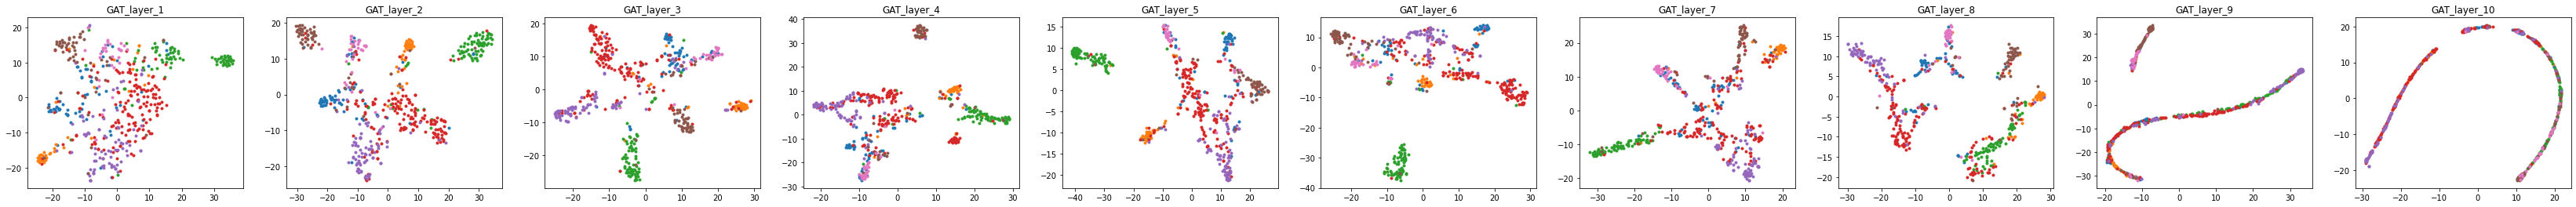

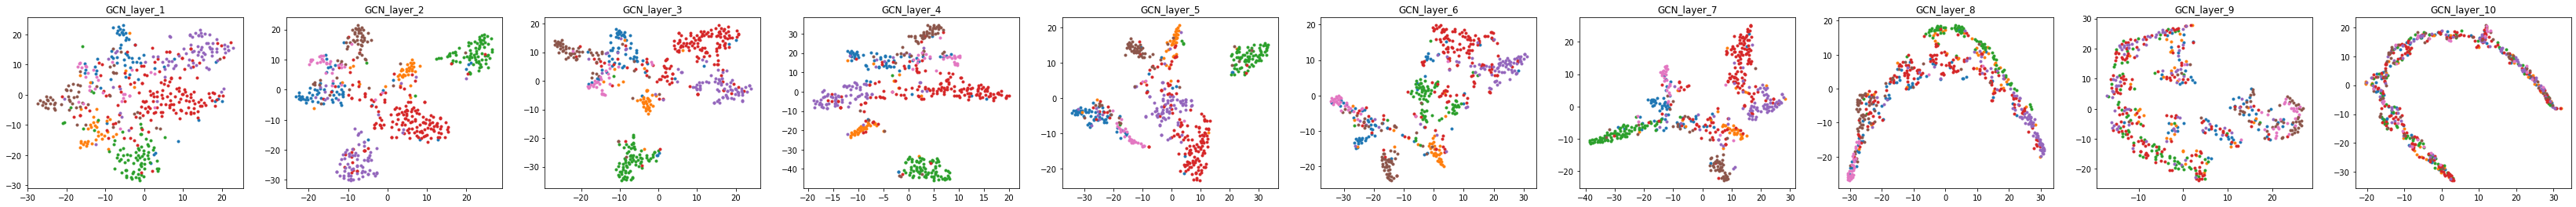

In [ ]:
visualise(feature_dict_GAT)
visualise(feature_dict_GCN)

In [ ]:
vis_savefig(feature_dict_GAT)
vis_savefig(feature_dict_GCN)

## Part 3: Skip Connections & Jumping Knowledge Connections




In this section, we will investigate whether skip connections and jumping knowledge connections can alleviate the effect of over-smoothing.

#### Method implementation

In [ ]:
class SkipGAT(nn.Module):
  def __init__(self, input_dim: int, hid_dim: int, n_classes: int, n_layers: int, dropout_ratio: float = 0.3):
    super(SkipGAT, self).__init__()
    self.n_layers = n_layers
    self.relu_layer = nn.ReLU()
    self.dropout_layer = nn.Dropout(dropout_ratio)
    if n_layers == 0:
      self.linear = nn.Linear(input_dim, n_classes)
    else:
      layers_list = []
      if n_layers == 1:
        layers_list.append(GATConv(input_dim, n_classes))
      else:
        layers_list.append(GATConv(input_dim, hid_dim))
        for i in range(n_layers - 2): 
          layers_list.append(GATConv(hid_dim, hid_dim))
        layers_list.append(GATConv(hid_dim, n_classes))
      self.layers = nn.ModuleList(layers_list)

  def forward(self, X, A) -> torch.Tensor:
    X = self.generate_node_embeddings(X, A)
    X = F.softmax(X, dim=1)
    return X

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    if self.n_layers == 0:
      X = self.linear(X)
    else:
      for i, layer in enumerate(self.layers):
        if i == 0:
          X = layer(X, A)
        elif i == self.n_layers-1:
          X = layer(X, A)
        else:
          input = X
          res = layer(X, A)
          X = input + res
          X = self.relu_layer(X)
          X = self.dropout_layer(X)
    return X
  
  def param_init(self):
    def _reset_module_parameters(module):
        for layer in module.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            elif hasattr(layer, 'children'):
                for child_layer in layer.children():
                    _reset_module_parameters(child_layer)
    _reset_module_parameters(self)

In [ ]:
class JumpKnowGAT(nn.Module):
  def __init__(self, input_dim: int, hid_dim: int, n_classes: int, n_layers: int, dropout_ratio: float = 0.3):
    super(JumpKnowGAT, self).__init__()
    self.n_layers = n_layers
    self.relu_layer = nn.ReLU()
    self.dropout_layer = nn.Dropout(dropout_ratio)
    if n_layers == 0:
      self.linear = nn.Linear(input_dim, n_classes)
    else:
      layers_list = []
      if n_layers == 1:
        layers_list.append(GATConv(input_dim, n_classes))
      else:
        layers_list.append(GATConv(input_dim, hid_dim))
        for i in range(n_layers - 2): 
          layers_list.append(GATConv(hid_dim, hid_dim))
        layers_list.append(GATConv(hid_dim, n_classes))
      self.layers = nn.ModuleList(layers_list)

  def forward(self, X, A) -> torch.Tensor:
    X = self.generate_node_embeddings(X, A)
    X = F.softmax(X, dim=1)
    return X

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    if self.n_layers == 0:
      X = self.linear(X)
    elif self.n_layers == 1:
      X = self.layers[-1](X, A)
    else:
      layer_outputs = []
      for i, layer in enumerate(self.layers[:-1]):
        X = layer(X, A)
        X = self.relu_layer(X)
        X = self.dropout_layer(X)
        layer_outputs.append(X)
      X_stack = torch.stack(layer_outputs, dim=0)
      X, _ = torch.max(X_stack,0)
      X = self.layers[-1](X, A)          
    return X
  
  def param_init(self):
    def _reset_module_parameters(module):
        for layer in module.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            elif hasattr(layer, 'children'):
                for child_layer in layer.children():
                    _reset_module_parameters(child_layer)
    _reset_module_parameters(self)

#### Experiments on n_layer: [5, 10, 15, 20, 25, 30]

In [ ]:
layer_nums = [5, 10, 15, 20, 25, 30]

In [ ]:
torch.manual_seed(1119)

model_layers_SkipGAT = []
for i in layer_nums:
  print_log("model:\t [GAT]+[Skip Connection] \t n_layer:\t" + str(i))
  PARAMS["n_layers"] = i
  model_SkipGAT = SkipGAT(PARAMS["input_dim"], PARAMS["hid_dim"], PARAMS["n_classes"], PARAMS["n_layers"]).to(device)
  model = train(model_SkipGAT, PARAMS)
  model_layers_SkipGAT.append(model)

model:	 [GAT]+[Skip Connection] 	 n_layer:	5
----------------------------------
Early Stopped at epoch:	21
Best Val Accuracy:	0.7960000038146973
----------------------------------
model:	 [GAT]+[Skip Connection] 	 n_layer:	10
----------------------------------
Early Stopped at epoch:	48
Best Val Accuracy:	0.7799999713897705
----------------------------------
model:	 [GAT]+[Skip Connection] 	 n_layer:	15
----------------------------------
Early Stopped at epoch:	13
Best Val Accuracy:	0.15600000321865082
----------------------------------
model:	 [GAT]+[Skip Connection] 	 n_layer:	20
----------------------------------
Early Stopped at epoch:	10
Best Val Accuracy:	0.11400000005960464
----------------------------------
model:	 [GAT]+[Skip Connection] 	 n_layer:	25
----------------------------------
Early Stopped at epoch:	12
Best Val Accuracy:	0.16200000047683716
----------------------------------
model:	 [GAT]+[Skip Connection] 	 n_layer:	30
----------------------------------
Early Stoppe

In [ ]:
torch.manual_seed(1119)

model_layers_JumpKnowGAT = []
for i in layer_nums:
  print_log("model:\t [GAT]+[Jumping Knowledge Connection] \t n_layer:\t" + str(i))
  PARAMS["n_layers"] = i
  model_JumpKnowGAT = JumpKnowGAT(PARAMS["input_dim"], PARAMS["hid_dim"], PARAMS["n_classes"], PARAMS["n_layers"]).to(device)
  model = train(model_JumpKnowGAT, PARAMS)
  model_layers_JumpKnowGAT.append(model)

model:	 [GAT]+[Jumping Knowledge Connection] 	 n_layer:	5
----------------------------------
Early Stopped at epoch:	28
Best Val Accuracy:	0.7639999985694885
----------------------------------
model:	 [GAT]+[Jumping Knowledge Connection] 	 n_layer:	10
----------------------------------
Early Stopped at epoch:	25
Best Val Accuracy:	0.7620000243186951
----------------------------------
model:	 [GAT]+[Jumping Knowledge Connection] 	 n_layer:	15
----------------------------------
Early Stopped at epoch:	21
Best Val Accuracy:	0.7639999985694885
----------------------------------
model:	 [GAT]+[Jumping Knowledge Connection] 	 n_layer:	20
----------------------------------
Early Stopped at epoch:	22
Best Val Accuracy:	0.7760000228881836
----------------------------------
model:	 [GAT]+[Jumping Knowledge Connection] 	 n_layer:	25
----------------------------------
Early Stopped at epoch:	26
Best Val Accuracy:	0.7620000243186951
----------------------------------
model:	 [GAT]+[Jumping Knowledg

In [ ]:
feature_dict_SkipGAT = {}
for i in range(len(layer_nums)):
  feature_dict_SkipGAT["SkipGAT_"+"layer_"+str(layer_nums[i])] = dimension_reduction(model_layers_SkipGAT[i])

In [ ]:
feature_dict_JumpKnowGAT = {}
for i in range(len(layer_nums)):
  feature_dict_JumpKnowGAT["JumpKnowGAT_"+"layer_"+str(layer_nums[i])] = dimension_reduction(model_layers_JumpKnowGAT[i])

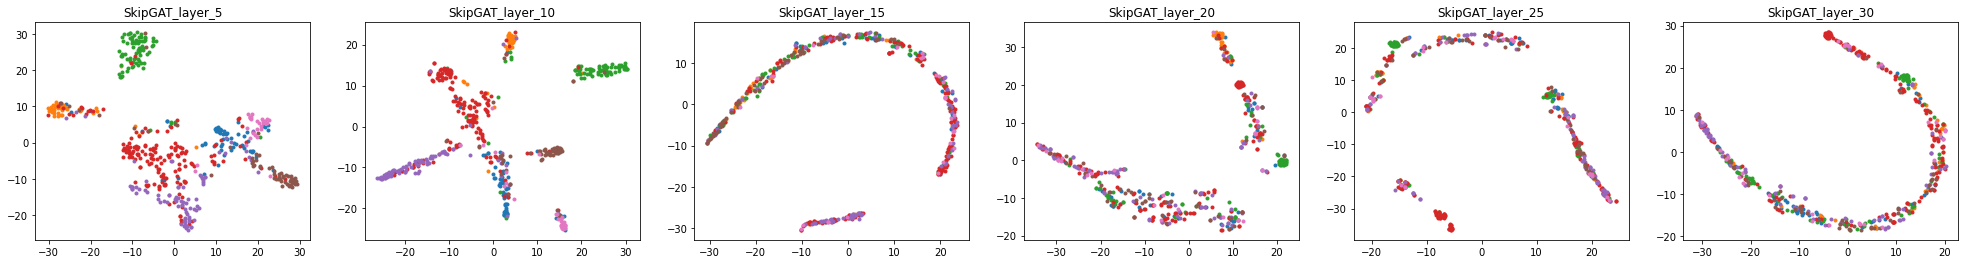

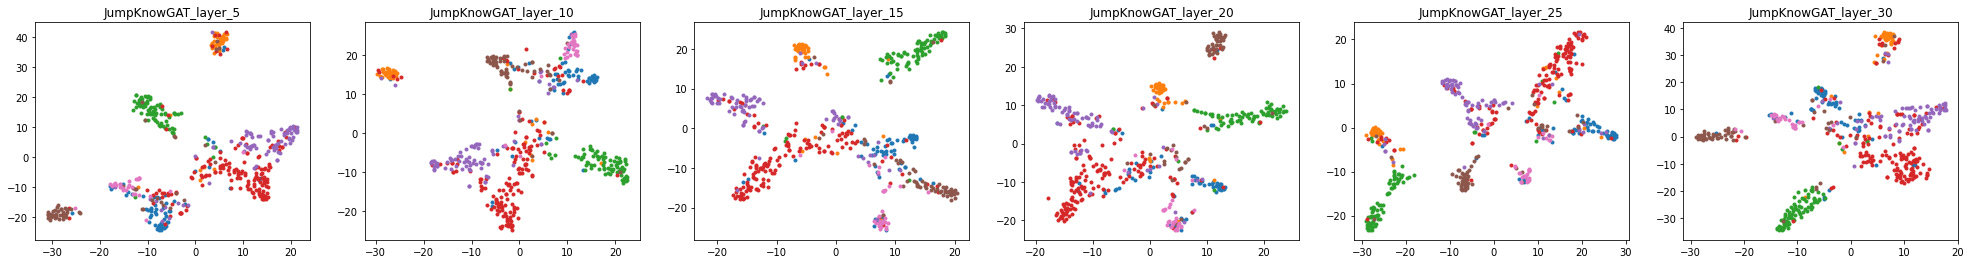

In [ ]:
visualise(feature_dict_SkipGAT)
visualise(feature_dict_JumpKnowGAT)

In [ ]:
vis_savefig(feature_dict_SkipGAT)
vis_savefig(feature_dict_JumpKnowGAT)

#### Skip connections: [11, 12, 13, 14]

Finer setting in layer numbers in [10,15] to find the threshold when over-smoothing happens. 

model:	 [GAT]+[Skip Connection] 	 n_layer:	11
----------------------------------
Early Stopped at epoch:	35
Best Val Accuracy:	0.7739999890327454
----------------------------------
model:	 [GAT]+[Skip Connection] 	 n_layer:	12
----------------------------------
Early Stopped at epoch:	41
Best Val Accuracy:	0.7360000014305115
----------------------------------
model:	 [GAT]+[Skip Connection] 	 n_layer:	13
----------------------------------
Early Stopped at epoch:	31
Best Val Accuracy:	0.5740000009536743
----------------------------------
model:	 [GAT]+[Skip Connection] 	 n_layer:	14
----------------------------------
Early Stopped at epoch:	10
Best Val Accuracy:	0.3160000145435333
----------------------------------


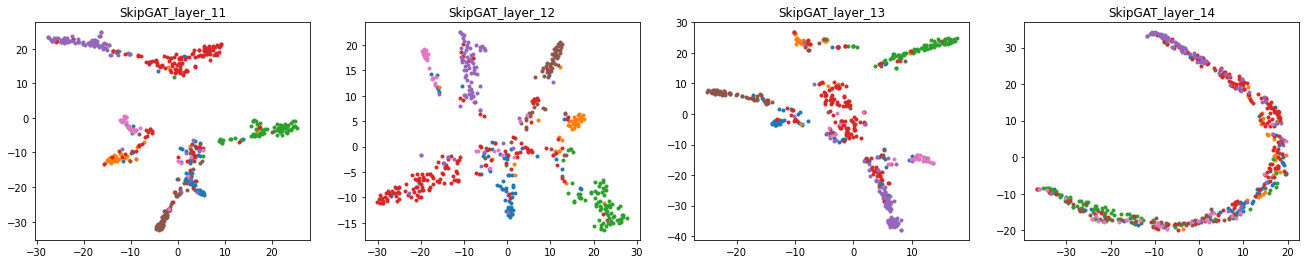

In [ ]:
layer_nums_skipGAT = [11, 12, 13, 14]
model_layers_SkipGAT = []
for i in layer_nums_skipGAT:
  print_log("model:\t [GAT]+[Skip Connection] \t n_layer:\t" + str(i))
  PARAMS["n_layers"] = i
  model_SkipGAT = SkipGAT(PARAMS["input_dim"], PARAMS["hid_dim"], PARAMS["n_classes"], PARAMS["n_layers"]).to(device)
  model = train(model_SkipGAT, PARAMS)
  model_layers_SkipGAT.append(model)

feature_dict_SkipGAT = {}
for i in range(len(layer_nums_skipGAT)):
  feature_dict_SkipGAT["SkipGAT_"+"layer_"+str(layer_nums_skipGAT[i])] = dimension_reduction(model_layers_SkipGAT[i])

visualise(feature_dict_SkipGAT)

In [ ]:
vis_savefig(feature_dict_SkipGAT)

#### Jumping knowledge connections: [40, 60, 80, 100]

Increase the number of layers to see the ability of jumping knowledge connection in addressing over-smoothing issue. 

model:	 [GAT]+[Jumping Knowledge Connection] 	 n_layer:	40
----------------------------------
Early Stopped at epoch:	21
Best Val Accuracy:	0.7720000147819519
----------------------------------
model:	 [GAT]+[Jumping Knowledge Connection] 	 n_layer:	60
----------------------------------
Early Stopped at epoch:	24
Best Val Accuracy:	0.7820000052452087
----------------------------------
model:	 [GAT]+[Jumping Knowledge Connection] 	 n_layer:	80
----------------------------------
Early Stopped at epoch:	26
Best Val Accuracy:	0.7799999713897705
----------------------------------
model:	 [GAT]+[Jumping Knowledge Connection] 	 n_layer:	100
----------------------------------
Early Stopped at epoch:	25
Best Val Accuracy:	0.7720000147819519
----------------------------------


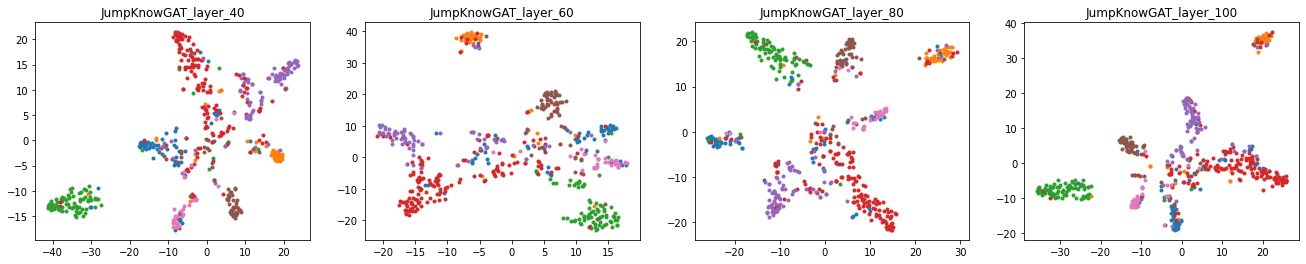

In [ ]:
layer_nums_jumpKnowGAT = [40, 60, 80, 100]

model_layers_JumpKnowGAT = []
for i in layer_nums_jumpKnowGAT:
  print_log("model:\t [GAT]+[Jumping Knowledge Connection] \t n_layer:\t" + str(i))
  PARAMS["n_layers"] = i
  model_JumpKnowGAT = JumpKnowGAT(PARAMS["input_dim"], PARAMS["hid_dim"], PARAMS["n_classes"], PARAMS["n_layers"]).to(device)
  model = train(model_JumpKnowGAT, PARAMS)
  model_layers_JumpKnowGAT.append(model)

feature_dict_JumpKnowGAT = {}
for i in range(len(layer_nums_jumpKnowGAT)):
  feature_dict_JumpKnowGAT["JumpKnowGAT_"+"layer_"+str(layer_nums_jumpKnowGAT[i])] = dimension_reduction(model_layers_JumpKnowGAT[i])

visualise(feature_dict_JumpKnowGAT)

In [ ]:
vis_savefig(feature_dict_JumpKnowGAT)